In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
#np.set_printoptions(threshold=sys.maxsize)
from scipy.signal import find_peaks, peak_widths
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from pandas import read_csv
from scipy import signal

: 

0.001

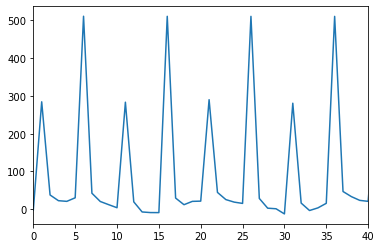

In [5]:
data = pd.read_csv('BL1.txt', delimiter='\t', header = None, skiprows=6)
pv = data[1].to_numpy()
T_s = data[0][1] - data[0][0]
timestamp = np.arange(start = 0, stop = len(pv)*T_s, step = T_s)
timestamp = timestamp[np.logical_not(np.isnan(timestamp))]
timestamp -= timestamp[0]

f_s = 1/T_s
increment_s = 0.01
timestamp_ds = np.arange(0, timestamp[-1], increment_s)
plt.plot(pv)
plt.xlim(0,40)


In [6]:
#decompose series
from statsmodels.tsa.seasonal import seasonal_decompose

def det_sea(sig, window_length_sa=20, period=100):
    sig_dec = seasonal_decompose(sig, model='additive', period=period)
    sig_adj = sig - sig_dec.seasonal - np.nan_to_num(sig_dec.trend)
    sig_den = np.convolve(sig_adj, np.ones(window_length_sa)/window_length_sa, mode='same')
    return sig_den

# red 
# notice: the value for red_offset_s and nir_offset would be changing depending on input data
red_offset_s = 0.011
red = pv[int(red_offset_s*f_s):-1:int(increment_s*f_s)]
red_den = det_sea(red)

# nir
nir_offset_s = 0.06
nir = pv[int(nir_offset_s*f_s):-1:int(increment_s*f_s)]
decompose_series = seasonal_decompose(nir, model='additive',period=100)
nir_den = det_sea(nir)



(200.0, 600.0)

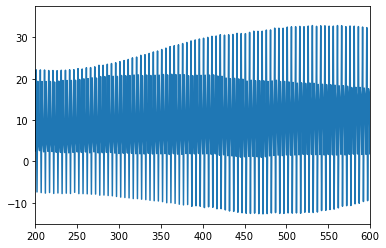

In [7]:
plt.plot(nir)
plt.xlim(200,600)
# plt.ylim(-0.05,0.05)

(-0.05, 0.05)

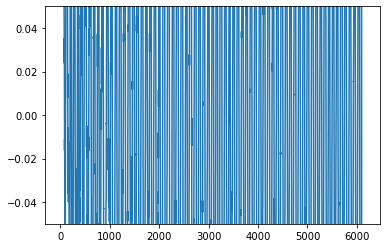

In [8]:
plt.plot(red_den)
#plt.xlim(200,600)
plt.ylim(-0.05,0.05)

In [9]:
peaks_red, _ = find_peaks(-red_den, distance=190)
peaks_nir, _ = find_peaks(-nir_den, distance=190)
adj_peaks_red = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_red, peaks_red+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)
adj_peaks_nir = np.concatenate(([0],
                                np.sort(np.row_stack([peaks_nir, peaks_nir+1]).flatten()),
                                [timestamp_ds[-1]/0.01])).reshape(-1,2).astype(int)

len(adj_peaks_red)


26

In [7]:
len(adj_peaks_nir)

26

In [81]:
#initialize
max_length_red = (adj_peaks_red[:,1]-adj_peaks_red[:,0]).max() # max length of denoised slices
n_slices_red = len(adj_peaks_red) # number of slices
max_length_nir = (adj_peaks_nir[:,1]-adj_peaks_nir[:,0]).max() # max length of denoised slices
n_slices_nir = len(adj_peaks_nir) # number of slices

slices_red = []
slices_nir = []
for i in range(n_slices_red):
    length_now_red = (adj_peaks_red[i,1]-adj_peaks_red[i,0])
    if length_now_red < max_length_red:
        slices_red.append(np.pad(red_den[adj_peaks_red[i,0]:adj_peaks_red[i,1]], (0, max_length_red-length_now_red), 'constant', constant_values = 0))
    else:
        slices_red.append(red_den[adj_peaks_red[i,0]:adj_peaks_red[i,1]])

for i in range(n_slices_nir):
    length_now_nir = (adj_peaks_nir[i,1]-adj_peaks_nir[i,0])
    if length_now_nir < max_length_nir:
        slices_nir.append(np.pad(nir_den[adj_peaks_nir[i,0]:adj_peaks_nir[i,1]], (0, max_length_nir-length_now_nir), 'constant', constant_values = 0))
    else:
        slices_nir.append(nir_den[adj_peaks_nir[i,0]:adj_peaks_nir[i,1]])

slices_red = np.array(slices_red)
slices_nir = np.array(slices_nir)



/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_3346/229968309.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  slices_nir = np.array(slices_nir)


26

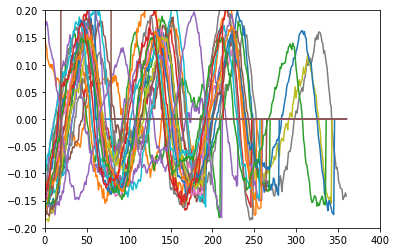

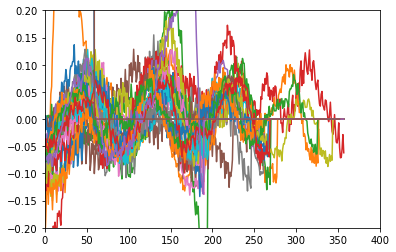

26

In [36]:
#plot for slices_red
for i in range(n_slices_red):
    plt.plot(slices_red[i])
plt.ylim(-0.2,0.2)
plt.xlim(0,400)
plt.show()

#plot for slices_nir
for i in range(n_slices_nir):
    plt.plot(slices_nir[i])
plt.ylim(-0.2,0.2)
plt.xlim(0,400)
plt.show()

#we obbserve there two outliers lines in each red and nir plot, and we are going to remove them in the next section.
len(slices_red)

In [2]:
#Next steps we need to do: 
#normalization, base line  -1,1
#remove curves with too many zeros
#pick a shortest curve, for any other curves longer than it, eg, 20 units longer, than remove a dot each 20 unit

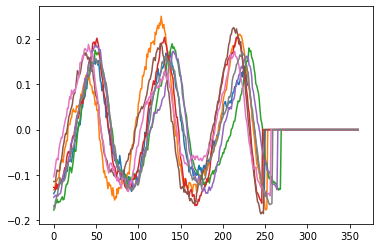

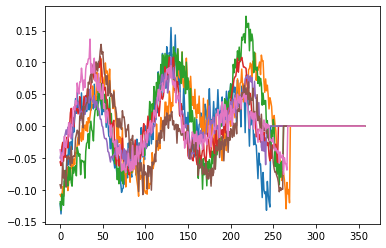

TypeError: len() takes exactly one argument (2 given)

In [85]:
#from scipy.signal import argrelextrema
#distance 50, 50*0.01s = 0.5s, so 120 heartbeats / min

#Note1: 
#the distance here is still 50 accroding to the distance where the first peak appears
#But we need to change the len(peaks_red/nir_new) > 3 instead of > 2 in sample data, as we observe in the two graphs above, 
#most of the curves have 3 peaks.
red_peaks = []
for i in range (n_slices_red):
    peaks_red_new, _ = find_peaks(slices_red[i], distance=50)
    if len(peaks_red_new) > 3 or (np.count_nonzero(slices_red[i] > 200)):
      red_peaks.append(i)
slices_red_twopeak = np.delete(slices_red, red_peaks, 0)

#note1:
#If we observe the plot of slices_red_twopeak, we will find out there are curves that remains two many zeros after a specific x-axis value,
#which means we need do further step to remove those curves containing too much zeros.

#note2:
#200 and 130 are variable depending on the input, we need to adjust these two values until our plot seems applicable.
red_peaks_zero = []
for i, arr in enumerate(slices_red_twopeak):
    if (arr[200:] == 0).sum() >= 120:
      red_peaks_zero.append(i)
slices_red_twopeak_nonzero = np.delete(slices_red_twopeak, red_peaks_zero, 0)

for i in range(len(slices_red_twopeak_nonzero)):
    plt.plot(slices_red_twopeak_nonzero[i])
plt.show()

#Note1:
#we've done adjusting the curves of red and now we move to the same procedure with nir. However, we delete curves in nir which have the 
#same index with the curves deleted in red in order to keep the number of curves in red and nir the same. 

#Note2:
#we fail to get the same number of curves after doing the same trick that is applicable in our sample data, here, after deleting same index
#of curve in red, the nir showed a mess,which means we have to do the following filtering procedure. 

nir_peaks = []
for i in range (n_slices_nir):
    peaks_nir_new, _ = find_peaks(slices_nir[i], distance=50)
    if len(peaks_nir_new) > 3 or (np.count_nonzero(slices_nir[i] > 150)):
      nir_peaks.append(i)
slices_nir_twopeak = np.delete(slices_nir, nir_peaks, 0)

nir_peaks_zero = []
for i, arr in enumerate(slices_nir_twopeak):
    if (arr[200:] == 0).sum() >= 150:
      nir_peaks_zero.append(i)
slices_nir_twopeak_nonzero = np.delete(slices_nir_twopeak, nir_peaks_zero, 0)

for i in range(len(slices_nir_twopeak_nonzero)):
   plt.plot(slices_nir_twopeak_nonzero[i])
plt.show()

(len(slices_nir_twopeak_nonzero), len(slices_red_twopeak_nonzero))
#Note: now, the two plots of red and nir after removing unfittable curves are fine, however, the problem is the number of curves are different:
#8 curves in red, while 7 curves in nir. Without loss of generality, my idea is to remove one curve that seems least fittable in red. By observing
#on the plot, I choose to delete the orange one because its second peak and first downpeak seems deviate a lot.

#Note, the following step is changing or unecessary depending on input.
adjust_for_red = []
for i in range (len(slices_red_twopeak_nonzero)):
  

  





4

In [67]:
#adjust curves to have same length

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

sum_red_zeros = []
sum_nir_zeros = []
sum_all_zeros = []
delete_red_index = []
delete_nir_index = []
normalized_red = []
normalized_nir = []
#因为有可能red和nir两个所有的max length不一样，那么不能单纯靠哪条线0的多少来加，说白了就是下面这一堆代码来保证在不同长度的情况下正确选出哪条线的0更多，然后
#筛出来让最后删掉curve 后所有max curve lenth是一样的，就说是从同一个x轴坐标点开始后面全是0就行了
for i in range (len(slices_red_twopeak_nonzero)):
    sum_red_zeros.append(np.sum(zero_runs(slices_red_twopeak_nonzero[i])[:,1] - zero_runs(slices_red_twopeak_nonzero[i])[:,0]))
    sum_nir_zeros.append(np.sum(zero_runs(slices_nir_twopeak_nonzero[i])[:,1] - zero_runs(slices_nir_twopeak_nonzero[i])[:,0]))
    sum_all_zeros = sum_red_zeros+sum_nir_zeros
if max(sum_red_zeros) < max(sum_nir_zeros):
    max_all_zeros_red = max_length_red - max_length_nir + max(sum_nir_zeros)
    max_all_zeros_nir = max(sum_nir_zeros)
elif max(sum_red_zeros) > max(sum_nir_zeros):
    max_all_zeros_nir = max_length_nir - max_length_red + max(sum_red_zeros)
    max_all_zeros_red = max(sum_red_zeros)
elif max(sum_red_zeros) == max(sum_nir_zeros):
    max_all_zeros_red = max(sum_red_zeros)
    max_all_zeros_nir = max_all_zeros_red

for i in range (len(slices_red_twopeak_nonzero)):
    x_red = len(slices_red_twopeak_nonzero[i])-sum_red_zeros[i]
    y_red = max_all_zeros_red-sum_red_zeros[i]
    delete_red_index = np.arange(0,x_red,x_red/y_red).astype(int)
    normalized_red.append((2*(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)-min(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)))/((max(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)) - min(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0)))))-1)
    plt.plot(np.delete(slices_red_twopeak_nonzero[i], delete_red_index, 0))
plt.show()


#for i in range (len(slices_nir_twopeak_nonzero)):
#    sum_red_zeros.append(np.sum(zero_runs(slices_red_twopeak_nonzero[i])[:,1] - zero_runs(slices_red_twopeak_nonzero[i])[:,0]))
#    sum_nir_zeros.append(np.sum(zero_runs(slices_nir_twopeak_nonzero[i])[:,1] - zero_runs(slices_nir_twopeak_nonzero[i])[:,0]))
#    sum_all_zeros = sum_red_zeros+sum_nir_zeros
for i in range (len(slices_nir_twopeak_nonzero)):
    x_nir = len(slices_nir_twopeak_nonzero[i])-sum_nir_zeros[i]
    y_nir = max_all_zeros_nir-sum_nir_zeros[i]
    delete_nir_index = np.arange(0,x_nir,x_nir/y_nir).astype(int)
    normalized_nir.append((2*(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)-min(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)))/((max(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)) - min(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0)))))-1)
    plt.plot(np.delete(slices_nir_twopeak_nonzero[i], delete_nir_index, 0))
plt.show()


#gz file

IndexError: index 7 is out of bounds for axis 0 with size 7

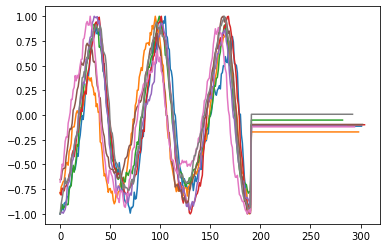

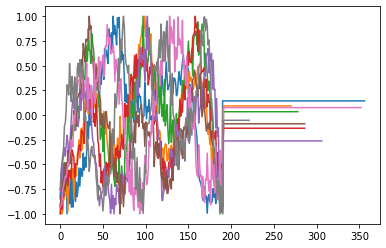

In [63]:
#plot for normalized data
for i in range (len(normalized_red)):
    plt.plot(normalized_red[i])
plt.show()
for i in range (len(normalized_nir)):
    plt.plot(normalized_nir[i])
plt.show()

In [64]:
#Below it's just a deep learning method for normalizing which is interesting while we don't apply that here.

#from sklearn.preprocessing import MaxAbsScaler

#transformer_red = MaxAbsScaler().fit(slices_red)
#MaxAbsScaler()
#normal_slices_red = transformer_red.transform(slices_red)
#for i in range(1, n_slices_red-2):
#    plt.plot(normal_slices_red[i])
#plt.show()

#transformer_nir = MaxAbsScaler().fit(slices_nir)
#MaxAbsScaler()
#normal_slices_nir = transformer_nir.transform(slices_nir)
#for i in range(1, n_slices_nir-1):
#    plt.plot(normal_slices_nir[i])
#plt.show()
